In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
from imageio import imread,imsave,mimsave
from tqdm import tqdm

In [2]:
image_list = glob.glob('Dataset/facades/train/*.jpg')+ glob.glob('Dataset/facades/val/*.jpg')
print(len(image_list))

500


In [3]:
X_list = []
Y_list = []
width = 256
height = 256
for image in image_list:
    img = imread(image)
    #print(img.shape)
    img = (img/255 - 0.5)*2 # scale to (-1,1)
    X_list.append(img[:,width:,:])
    Y_list.append(img[:,:width,:])
X_list = np.array(X_list)
Y_list = np.array(Y_list)
print(X_list.shape,Y_list.shape)

(500, 256, 256, 3) (500, 256, 256, 3)


In [4]:
batch_size = 1
LAMBDA = 100
output_dir = './Results'
X = tf.placeholder(dtype=tf.float32,shape=[None,height,width,3],name='X')
Y = tf.placeholder(dtype=tf.float32,shape=[None,height,width,3],name='Y')

k_initializer = tf.random_normal_initializer(0,0.02)
g_initializer = tf.random_normal_initializer(1,0.02)

def leakyrelu(x,leak=0.2):
    return tf.maximum(x,leak *x)

def d_conv(inputs,filters, strides):
    padded = tf.pad(inputs,[[0,0],[1,1],[1,1],[0,0]],mode='constant')
    return tf.layers.conv2d(padded,kernel_size=4, filters=filters, strides=strides,padding='valid',kernel_initializer=k_initializer)

def g_conv(inputs, filters):
    return tf.layers.conv2d(inputs,kernel_size=4, filters=filters, strides=2,padding='SAME',kernel_initializer=k_initializer)

def g_deconv(inputs,filters):
    return tf.layers.conv2d_transpose(inputs,kernel_size=4, filters=filters,strides=2,padding='SAME',kernel_initializer=k_initializer)

def batch_norm(inputs):
    return tf.layers.batch_normalization(inputs,axis=3,epsilon=1e-5,momentum=0.1,training=True, gamma_initializer=g_initializer)

def sigmoid_cross_entropy_with_logits(x,y):
    return tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=x)

# Discriminator

In [5]:
#Discriminator
def discriminator(x,y,reuse=None):
    with tf.variable_scope('discriminator',reuse=reuse):
        x = tf.concat([x,y],axis=3)

        h0 = leakyrelu(d_conv(x,64,2))#output_size(256/2=128,128,64)

        h1 = d_conv(h0,128,2)
        h1 = leakyrelu(batch_norm(h1))#output_size(64,64,128)

        h2 = d_conv(h1, 256, 2)
        h2 = leakyrelu(batch_norm(h2))  # output_size(32,32,256)

        h3 = d_conv(h2, 512, 1)
        h3 = leakyrelu(batch_norm(h3))  # output_size(31,31,512)

        h4 = d_conv(h3, 1, 1)
        h4 = tf.nn.sigmoid(h4,name='d')  # output_size(30,30,1)

        return h4

# Generator

In [6]:
# Generator
def generator(x):
    with tf.variable_scope('generator',reuse=None):
        layers = []
        h = g_conv(x,64)
        layers.append(h)

        for filters in [128,256,512,512,512,512,512]:
            h = leakyrelu(layers[-1]) # The last element of layers
            h = g_conv(h,filters)
            h = batch_norm(h)
            #print(filters," ",h.shape)
            layers.append(h)

        encoder_layers_num = len(layers) #8
        #print(encoder_layers_num)

        for i, filters in enumerate([512,512,512,512,256,128,64]):
            skip_layer = encoder_layers_num - i - 1
            if i == 0:
                inputs = layers[-1]
            else:
                inputs = tf.concat([layers[-1],layers[skip_layer]],axis=3)
            h = tf.nn.relu(inputs)
            h = g_deconv(h,filters)
            h = batch_norm(h)
            if i<3:
                h = tf.nn.dropout(h,keep_prob=0.5)
            layers.append(h)

        inputs = tf.concat([layers[-1],layers[0]],axis=3)
        h = tf.nn.relu(inputs)
        h = g_deconv(h,3)
        h = tf.nn.tanh(h,name='g')
        return(h)


# Loss Function

In [7]:
# Loss function
g = generator(X)
d_real = discriminator(X,Y)
d_fake = discriminator(X,g,reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

with tf.name_scope('loss_d'):
    loss_d_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_real,tf.ones_like(d_real)))
    loss_d_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake,tf.zeros_like(d_fake)))
    loss_d = loss_d_real+loss_d_fake
    tf.summary.scalar('loss_d',loss_d)

with tf.name_scope('loss_g'):
    loss_g_gan = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake,tf.ones_like(d_fake)))
    loss_l1 = tf.reduce_mean(tf.abs(Y-g))
    loss_g = loss_g_gan + loss_l1 * LAMBDA
    tf.summary.scalar('loss_g',loss_g)

# Optimizer

In [ ]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

# Training

  0%|          | 0/20 [00:00<?, ?it/s]

0 1.4681778 40.650967


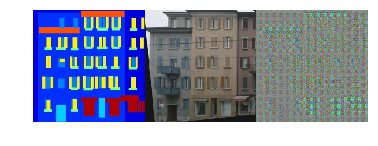

 50%|█████     | 10/20 [00:18<00:16,  1.63s/it]

10 1.3927174 36.111073


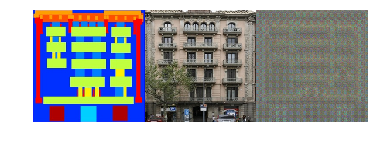

100%|██████████| 20/20 [00:34<00:00,  1.61s/it]


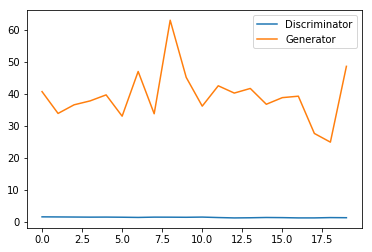

In [9]:
# Training
sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss = {'d':[],'g':[]}

merge_d_summary = tf.summary.merge([tf.get_collection(tf.GraphKeys.SUMMARIES,'loss_d')])
merge_g_summary = tf.summary.merge([tf.get_collection(tf.GraphKeys.SUMMARIES,'loss_g')])                       
writer = tf.summary.FileWriter("logs/", sess.graph)

for i in tqdm(range(100000)):
    k = i%X_list.shape[0]
    X_batch,Y_batch = X_list[k:k+batch_size,:,:,:],Y_list[k:k+batch_size,:,:,:]
    _, d_loss,d_l_summary = sess.run([optimizer_d, loss_d,merge_d_summary], feed_dict={X: X_batch, Y: Y_batch})
    _, g_loss,g_l_summary = sess.run([optimizer_g, loss_g,merge_g_summary], feed_dict={X: X_batch, Y: Y_batch})
    
    writer.add_summary(d_l_summary,i)
    writer.add_summary(g_l_summary,i)
                                    
    loss['d'].append(d_loss)
    loss['g'].append(g_loss)

    if i%1000 == 0:
        print(i,d_loss,g_loss)
        gen_img = sess.run(g,feed_dict={X:X_batch})
        result = np.zeros([height,width*3,3])# output:original picture(Y+X)+generated picture
        result[:,:width,:] = (X_batch[0]+1)/2
        result[:,width:2*width,:] = (Y_batch[0]+1)/2
        result[:,2*width:,:] = (gen_img[0]+1)/2
        plt.axis('off')
        plt.imshow(result)
        imsave(os.path.join(output_dir,'result_%d.jpg'%i),result)
        plt.show()



plt.plot(loss['d'],label='Discriminator')
plt.plot(loss['g'],label='Generator')
plt.legend(loc='upper right')
plt.savefig('Loss.png')
plt.show()